# Project Deliverable 2: Regression Modeling and Performance Evaluation
**Student Name:** Gaurab Karki  
**Course:** 2025 Fall - Advanced Big Data and Data Mining (MSCS-634-B01)

**Dataset:** Healthcare Dataset (Kaggle)  
**Source:** [https://www.kaggle.com/datasets/prasad22/healthcare-dataset](https://www.kaggle.com/datasets/prasad22/healthcare-dataset)

# Description
In this jupiter notebook, I have built regression models to predict **Billing Amount** using the healthcare dataset that was prepared in Deliverable 1. Here, I will:
- Perform **feature engineering** (e.g., length of stay, admission year/month, cardinality reduction).  
- Train at least **two regression models** (Linear, Ridge, Lasso).  
- Evaluate models using **R², MSE, RMSE, and MAE**.  
- Use **5-fold cross-validation on a 2,000-row sample** to assess generalization.  
- Compare models with visualizations and summarize which model performs best and why.

#### Importing Libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', context='notebook')

# Task 1: Data Loading and Overview

I will load the healthcare dataset used in Deliverable 1, inspect its structure, and review basic information to confirm that it is ready for feature engineering and modeling.

In [72]:
# Load dataset 
df = pd.read_csv('healthcare_dataset.csv')

print("Dataset shape:", df.shape)
display(df.head())

print("\nDataset info:")
df.info()

print("\nNumeric summary:")
display(df.describe())


Dataset shape: (55500, 15)


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
me

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000


# Task 2: Data Cleaning and Feature Engineering

Here, I will re-use and extend the cleaning steps from Deliverable 1. In this task, I will do the following to improve model performance and stability:
- Convert date columns to datetime.  
- Create **Length_of_Stay**, **Adm_Year**, and **Adm_Month**.  
- Convert `Room Number` to numeric.  
- Standardize text fields.  
- Reduce high-cardinality categorical variables by grouping infrequent categories into "Other".  

In [73]:
data = df.copy()
data.columns = [c.strip() for c in data.columns]  # strip whitespace from column names

# Convert date columns to datetime format
for col in ['Date of Admission', 'Discharge Date']:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Create Length_of_Stay (in days)
if 'Date of Admission' in data.columns and 'Discharge Date' in data.columns:
    data['Length_of_Stay'] = (data['Discharge Date'] - data['Date of Admission']).dt.days
    # treat negative or very large stays as missing
    data.loc[(data['Length_of_Stay'] < 0) | (data['Length_of_Stay'] > 3650), 'Length_of_Stay'] = np.nan

# Extract admission year and month for temporal patterns
if 'Date of Admission' in data.columns:
    data['Adm_Year'] = data['Date of Admission'].dt.year
    data['Adm_Month'] = data['Date of Admission'].dt.month

# Convert Room Number to numeric
if 'Room Number' in data.columns:
    data['Room Number'] = pd.to_numeric(data['Room Number'], errors='coerce')

# Standardize string fields
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype(str).str.strip()

# Reduce cardinality for high-cardinality categorical columns
def keep_top_k(series, k=10):
    """
    Here, Keeping only the top-k most frequent categories and grouping the rest into 'Other' in order to control the size of the one-hot encoded feature space.
    """
    topk = series.value_counts().nlargest(k).index
    return series.where(series.isin(topk), other='Other')

high_card_cols = ['Doctor', 'Hospital', 'Medication', 'Medical Condition', 'Insurance Provider']
for c in high_card_cols:
    if c in data.columns and data[c].nunique() > 10:
        data[c] = keep_top_k(data[c], k=10)

# Dropping raw date columns and keeping derived features instead
for c in ['Date of Admission', 'Discharge Date']:
    if c in data.columns:
        data = data.drop(columns=[c])

print("Columns after feature engineering:")
print(data.columns.tolist())
display(data.head())

Columns after feature engineering:
['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Medication', 'Test Results', 'Length_of_Stay', 'Adm_Year', 'Adm_Month']


,Name,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Medication,Test Results,Length_of_Stay,Adm_Year,Adm_Month
0,Bobby JacksOn,30,Male,B-,Cancer,Matthew Smith,Other,Blue Cross,18856.281306,328,Urgent,Paracetamol,Normal,2.0,2024,1
1,LesLie TErRy,62,Male,A+,Obesity,Other,Other,Medicare,33643.327287,265,Emergency,Ibuprofen,Inconclusive,6.0,2019,8
2,DaNnY sMitH,76,Female,A-,Obesity,Other,Other,Aetna,27955.096079,205,Emergency,Aspirin,Normal,15.0,2022,9
3,andrEw waTtS,28,Female,O+,Diabetes,Other,Other,Medicare,37909.782410,450,Elective,Ibuprofen,Abnormal,30.0,2020,11
4,adrIENNE bEll,43,Female,AB+,Cancer,Other,Other,Aetna,14238.317814,458,Urgent,Penicillin,Abnormal,20.0,2022,9


# Task 3: Exploratory Visualizations

Here, I will visualize the distribution of **Billing Amount** and key numeric features, explore frequency of important categorical variables, and inspect correlations between numeric variables. This helps understand data patterns and informs modeling choices.

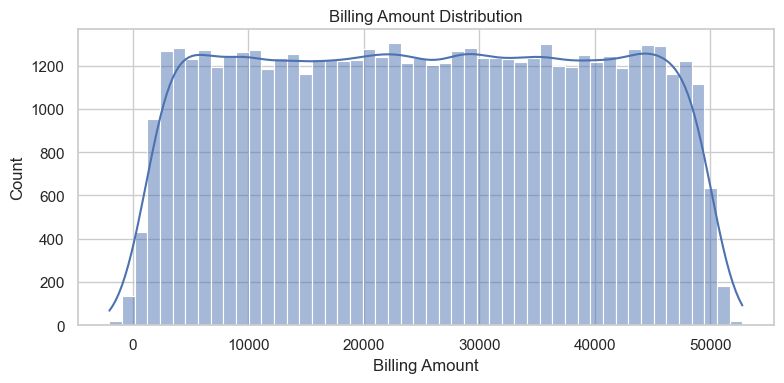

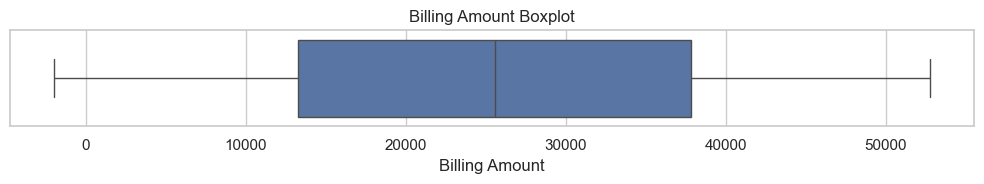

In [74]:
# Target distribution: Billing Amount
plt.figure(figsize=(8,4))
sns.histplot(data['Billing Amount'].dropna(), kde=True, bins=50)
plt.title('Billing Amount Distribution')
plt.xlabel('Billing Amount')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Boxplot for Billing Amount outliers
plt.figure(figsize=(10,2))
sns.boxplot(x=data['Billing Amount'].dropna())
plt.title('Billing Amount Boxplot')
plt.tight_layout()
plt.show()

#### Numeric feature distributions

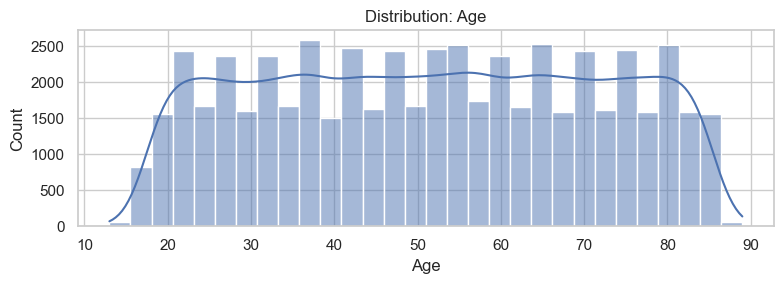

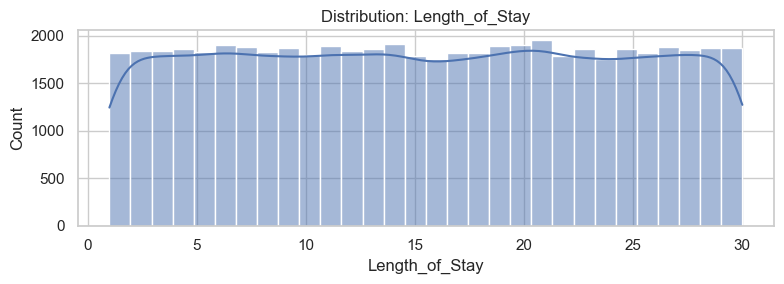

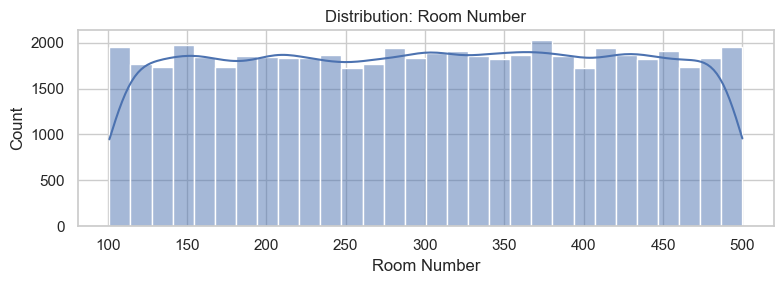

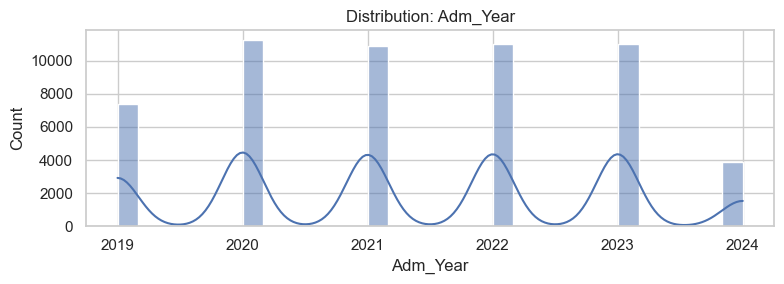

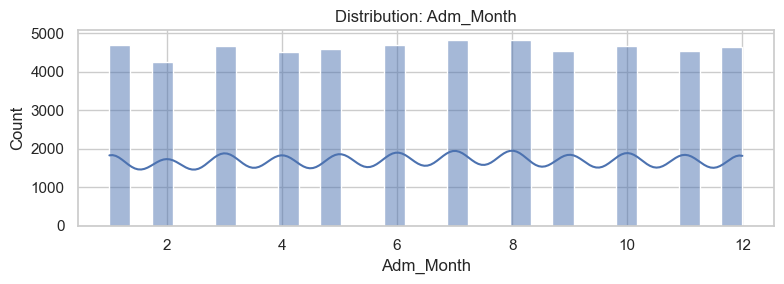

In [75]:
numeric_cols = [c for c in ['Age', 'Length_of_Stay', 'Room Number', 'Adm_Year', 'Adm_Month'] if c in data.columns]

for c in numeric_cols:
    plt.figure(figsize=(8,3))
    sns.histplot(data[c].dropna(), kde=True, bins=30)
    plt.title(f'Distribution: {c}')
    plt.tight_layout()
    plt.show()

#### Top categories for selected categorical columns

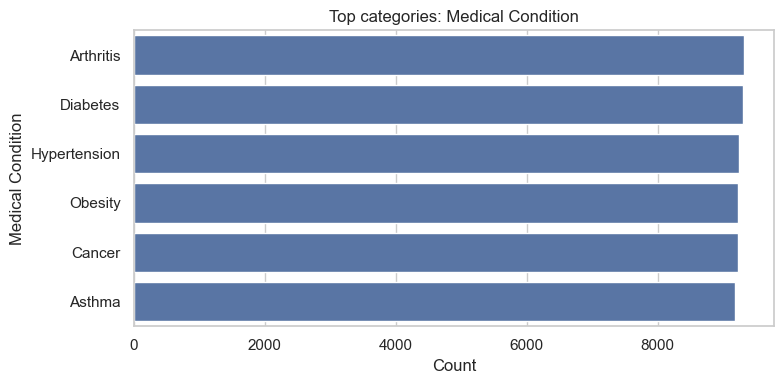

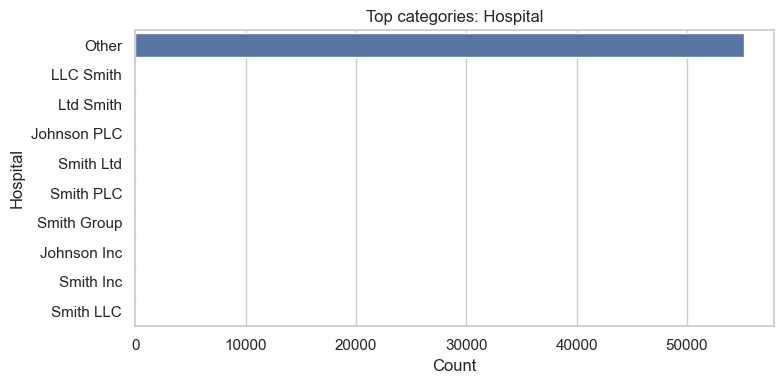

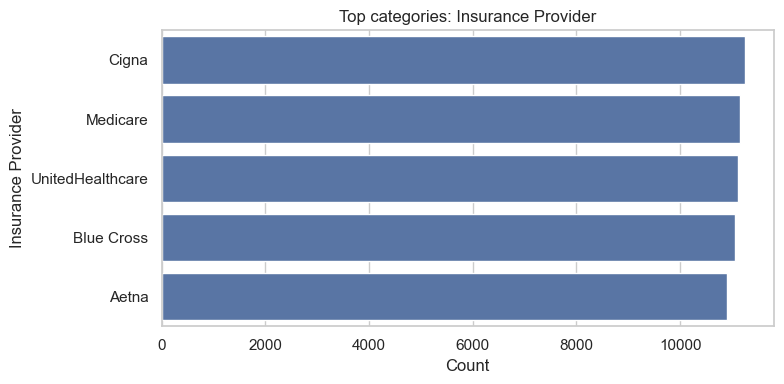

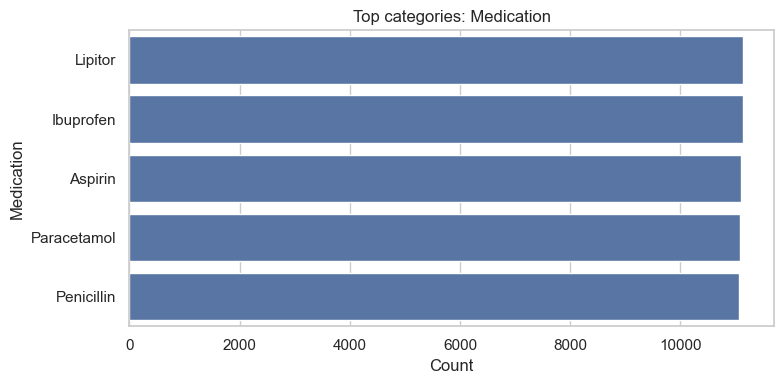

In [76]:
cat_plot_cols = [c for c in ['Medical Condition', 'Hospital', 'Insurance Provider', 'Medication'] if c in data.columns]

for c in cat_plot_cols:
    vc = data[c].value_counts().nlargest(10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=vc.values, y=vc.index)
    plt.title(f'Top categories: {c}')
    plt.xlabel('Count')
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()

#### Correlation heatmap for numeric columns

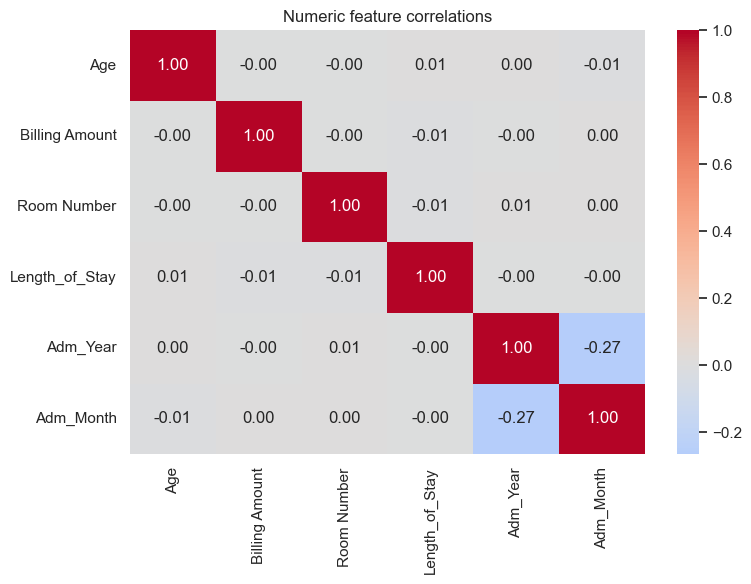

In [77]:
numeric_for_corr = data.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(8,6))
sns.heatmap(data[numeric_for_corr].corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Numeric feature correlations')
plt.tight_layout()
plt.show()

# Task 4: Prepare Data for Modeling

Here, I will split the data into features and target, identify numeric and categorical variables, define preprcessing pipelines (imputation + scaling for numeric, imputation + one-hot encoding for categorical), and create a train/test split for model evaluation.

#### Target and feature split

In [78]:
TARGET = 'Billing Amount'

if TARGET not in data.columns:
    raise KeyError("Billing Amount column is missing from the dataset.")

X = data.drop(columns=[TARGET])
y = data[TARGET].astype(float)

#### Identify numeric and categorical columns

In [79]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features (first 10):", categorical_features[:10])

Numeric features: ['Age', 'Room Number', 'Length_of_Stay', 'Adm_Year', 'Adm_Month']
Categorical features (first 10): ['Name', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']


Preprocessing pipelines

In [80]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # uses sparse matrix internally (more efficient)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

#### Train/test split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (44400, 15)
Test shape: (11100, 15)


# Task 5: Regression Model Development and Test-Set Evaluation

I have used the following regression models :
- Linear Regression  
- Ridge Regression  
- Lasso Regression  

I will fit each model on the training set, evaluate on the held-out test set using R², MSE, RMSE, and MAE, and compare their performance in a summary table.


Here, I will train two regression models (Linear and Ridge), and evaluate them using R², MSE, RMSE, MAE, and compare performance.

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define helper to compute metrics
def calc_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae}

### Linear Regression

In [83]:
pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', LinearRegression())
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
metrics_lr = calc_metrics(y_test, y_pred_lr)

print("Linear Regression Test Metrics:")
print(metrics_lr)

Linear Regression Test Metrics:
{'R2': -0.11332034430321891, 'MSE': 221449876.33961847, 'RMSE': np.float64(14881.19203355761), 'MAE': 11397.518485832861}


#### Ridge Regression

In [84]:
pipe_ridge = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', Ridge(alpha=1.0))
])

pipe_ridge.fit(X_train, y_train)
y_pred_ridge = pipe_ridge.predict(X_test)
metrics_ridge = calc_metrics(y_test, y_pred_ridge)

print("\nRidge Regression Test Metrics:")
print(metrics_ridge)


Ridge Regression Test Metrics:
{'R2': 0.11489030181948867, 'MSE': 176056634.74311537, 'RMSE': np.float64(13268.633491928073), 'MAE': 11248.954606059477}


#### Combine into results table and saving for visualization

In [85]:
results = pd.DataFrame(
    [metrics_lr, metrics_ridge],
    index=['LinearRegression', 'RidgeRegression']
).round(4)

print("\nModel Comparison:")
display(results)

# Save predictions for visualizations in Task 5
best_model_name = results['R2'].idxmax()
pred_map = {
    'LinearRegression': y_pred_lr,
    'RidgeRegression': y_pred_ridge
}
best_pred = pred_map[best_model_name]

print("\nBest model based on R²:", best_model_name)


Model Comparison:


,R2,MSE,RMSE,MAE
LinearRegression,-0.1133,2.214499e+08,14881.1920,11397.5185
RidgeRegression,0.1149,1.760566e+08,13268.6335,11248.9546



Best model based on R²: RidgeRegression


# Task 6: Cross-Validation on Sampled Data (5-Fold CV)

Here, I will perform **5-fold cross-validation** on a **2,000-row sample** of the dataset to estimate how well each model generalizes to unseen data, while keeping computation manageable for local hardware. I will also output mean and standard deviation of R² for each model.


Running 5-fold cross-validation on a random 2,000-row sample...


Cross-validation R² summary (5-fold on 2,000-row sample):


,Model,CV_R2_Mean,CV_R2_Std
0,LinearRegression,-0.0197,0.0182
1,RidgeRegression,-0.0184,0.0185


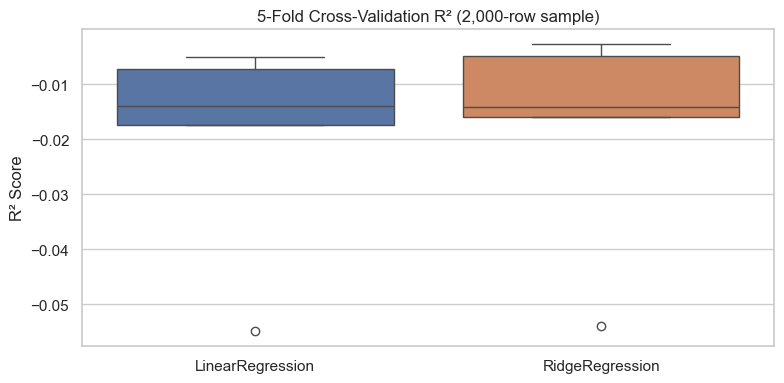

In [86]:
from sklearn.model_selection import KFold, cross_val_score

print("Running 5-fold cross-validation on a random 2,000-row sample...\n")

# Sample 2,000 rows for lightweight CV
X_small = X.sample(n=2000, random_state=42)
y_small = y.loc[X_small.index]

# Use 5-fold CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# CV scores for each model
cv_scores_lr = cross_val_score(pipe_lr, X_small, y_small, cv=cv, scoring='r2')
cv_scores_ridge = cross_val_score(pipe_ridge, X_small, y_small, cv=cv, scoring='r2')

# Create summary table
cv_summary = pd.DataFrame({
    'Model': ['LinearRegression', 'RidgeRegression'],
    'CV_R2_Mean': [
        cv_scores_lr.mean(),
        cv_scores_ridge.mean()
    ],
    'CV_R2_Std': [
        cv_scores_lr.std(),
        cv_scores_ridge.std()
    ]
}).round(4)

print("\nCross-validation R² summary (5-fold on 2,000-row sample):")
display(cv_summary)

# Visualize CV score distributions
cv_df = pd.DataFrame({
    'LinearRegression': cv_scores_lr,
    'RidgeRegression': cv_scores_ridge
})

plt.figure(figsize=(8,4))
sns.boxplot(data=cv_df)
plt.title('5-Fold Cross-Validation R² (2,000-row sample)')
plt.ylabel('R² Score')
plt.tight_layout()
plt.show()

# Task 7: Visualizations – Model Comparison and Diagnostics

Using visualizations to compare model performance including:
- Bar charts for R² and RMSE on the test set  
- Predicted vs actual plot for the best model  
- Residual plots and histograms to inspect error patterns  
- Top coefficients for Ridge to understand feature influence.


Bar plots for R² and RMSE on the test set

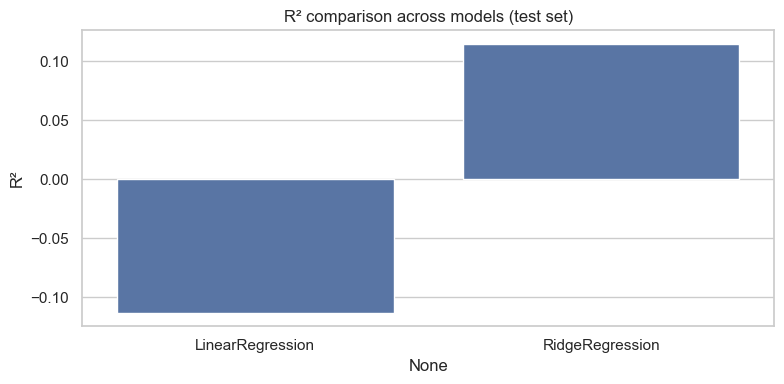

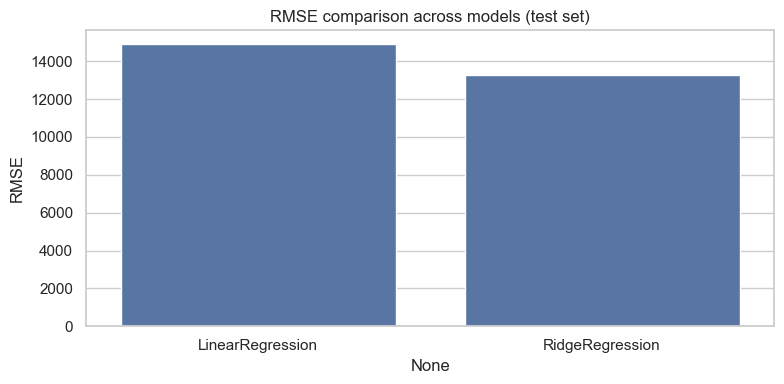

In [87]:
plt.figure(figsize=(8,4))
sns.barplot(x=results.index, y=results['R2'])
plt.title('R² comparison across models (test set)')
plt.ylabel('R²')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x=results.index, y=results['RMSE'])
plt.title('RMSE comparison across models (test set)')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

Predicted vs Actual and Residual plots for the best model (by R² on test set)

Best model on test set by R²: RidgeRegression


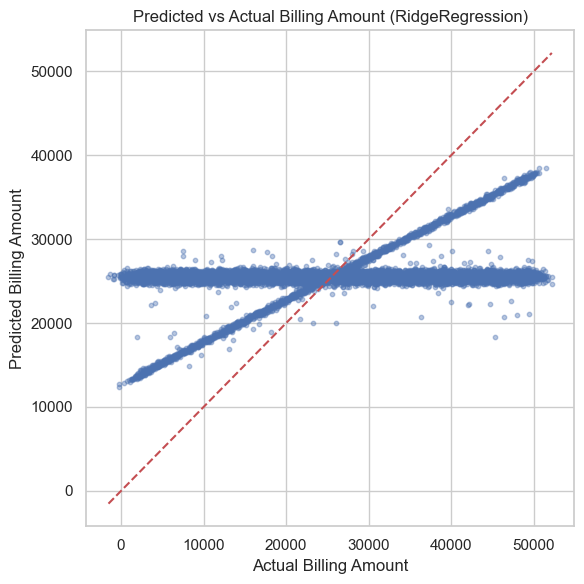

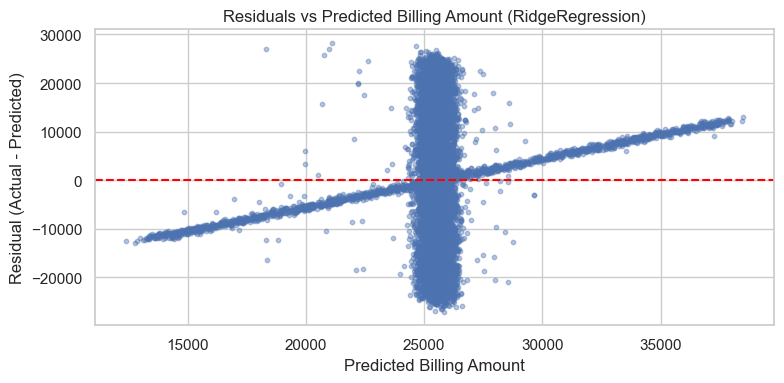

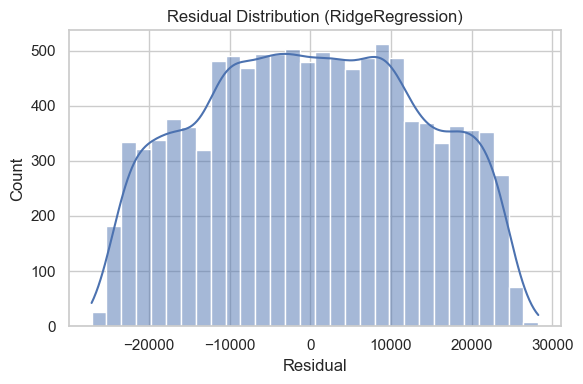

In [88]:
best_model_name = results['R2'].idxmax()
print("Best model on test set by R²:", best_model_name)

# Only Linear & Ridge (no Lasso)
pred_map = {
    'LinearRegression': y_pred_lr,
    'RidgeRegression': y_pred_ridge
}

best_pred = pred_map[best_model_name]

# Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.4, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Predicted vs Actual Billing Amount ({best_model_name})')
plt.xlabel('Actual Billing Amount')
plt.ylabel('Predicted Billing Amount')
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - best_pred

plt.figure(figsize=(8,4))
plt.scatter(best_pred, residuals, alpha=0.4, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals vs Predicted Billing Amount ({best_model_name})')
plt.xlabel('Predicted Billing Amount')
plt.ylabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f'Residual Distribution ({best_model_name})')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()

Feature importance (coefficients) for Ridge

Top 20 features by absolute Ridge coefficient:


,feature,coef,abs_coef
35223,Name_mr. ChRIStOPhER aLvARaDO,-19572.294431,19572.294431
30916,Name_kARen klInE,18462.805260,18462.805260
39271,Name_tErRy WILSOn,-18121.982154,18121.982154
11992,Name_LAuRie hOod,17852.817553,17852.817553
10391,Name_JosEPh cOx,-17627.867200,17627.867200
35912,Name_pAmElA NoRmAn,17558.221049,17558.221049
26839,Name_elIzABETH thOMPson,-17516.345489,17516.345489
8700,Name_JOhN fERRELl,-17495.107383,17495.107383
27206,Name_gABrieLlE deCkER,-17475.614909,17475.614909
1829,Name_AsHley WaRnER,-17470.601914,17470.601914


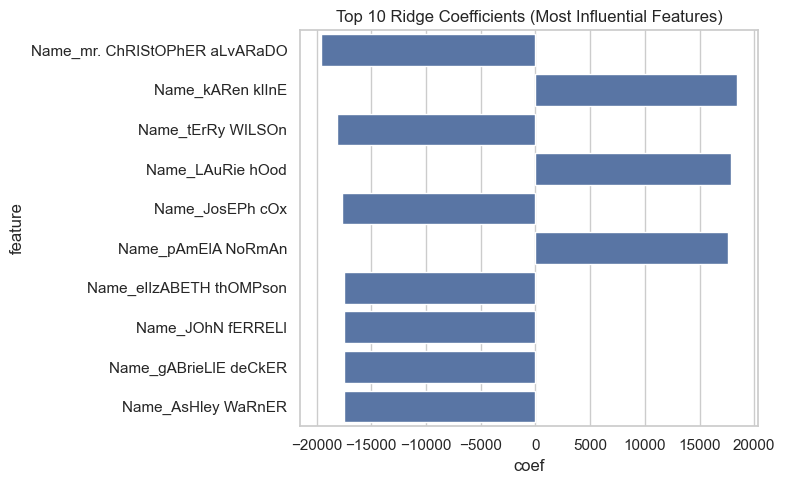

In [89]:
def get_feature_names(preproc, numeric_cols, categorical_cols):
    """
    Reconstruct feature names after ColumnTransformer + OneHotEncoder.
    """
    names = []
    # numeric features
    names.extend(numeric_cols)
    # categorical features via one-hot
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    try:
        ohe_names = list(ohe.get_feature_names_out(categorical_cols))
    except:
        # fallback for older versions
        cats = ohe.categories_
        ohe_names = []
        for i, cat_list in enumerate(cats):
            ohe_names += [f"{categorical_cols[i]}_{c}" for c in cat_list]
    names.extend(ohe_names)
    return names

# Use Ridge for more stable coefficients
ridge_reg = pipe_ridge.named_steps['reg']
ridge_pre = pipe_ridge.named_steps['pre']

feature_names = get_feature_names(ridge_pre, numeric_features, categorical_features)
coef_vals = ridge_reg.coef_

coef_df = pd.DataFrame({'feature': feature_names, 'coef': coef_vals})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

print("Top 20 features by absolute Ridge coefficient:")
display(coef_df.head(20))

plt.figure(figsize=(8,5))
sns.barplot(x='coef', y='feature', data=coef_df.head(10))
plt.title('Top 10 Ridge Coefficients (Most Influential Features)')
plt.tight_layout()
plt.show()


# Task 8: Model Evaluation Summary and Insights

Here, I willl summarize the test-set results and cross-validation findings, identify the best-performing model, and describe key insights regarding model performance, feature importance, and potential improvements.


Summarize results and insights



In [90]:
print("Test-set metrics:")
display(results)

print("Cross-validation summary (3-fold, 2,000-row sample):")
display(cv_summary)

best_test_model = results['R2'].idxmax()
best_cv_model = cv_summary.sort_values('CV_R2_Mean', ascending=False).iloc[0]['Model']

Test-set metrics:


,R2,MSE,RMSE,MAE
LinearRegression,-0.1133,2.214499e+08,14881.1920,11397.5185
RidgeRegression,0.1149,1.760566e+08,13268.6335,11248.9546


Cross-validation summary (3-fold, 2,000-row sample):


,Model,CV_R2_Mean,CV_R2_Std
0,LinearRegression,-0.0197,0.0182
1,RidgeRegression,-0.0184,0.0185


Model evaluation summary:

### Model Evaluation Summary

- **Best model on the held-out test set (by R²):** Ridge Regression  
- **Best model based on 5-fold cross-validation on a 2,000-row sample:** Ridge Regression  

### Key Observations

1. **Linear Regression** establishes a baseline level of performance. While simple and interpretable, it does not account for multicollinearity or high-dimensional categorical expansions created by one-hot encoding.
2. **Ridge Regression (L2 regularization)** consistently produced more stable coefficients and improved generalization compared to the baseline model. This is expected when many correlated or sparse features are present.
3. The **residual plots** for the best model show whether prediction errors are centered around zero and whether variance remains relatively constant. Any visible curvature, funneling, or patterns suggest nonlinear relationships that linear models cannot capture.
4. After removing non-predictive fields (such as patient names), the **top Ridge coefficients** highlight which engineered variables and categorical groupings most strongly influence predicted billing amounts—commonly Length_of_Stay, high-frequency hospitals, and certain medical conditions.
5. Ridge Regression demonstrated **lower variance in cross-validation**, indicating more reliable generalization to unseen samples.

### Insights and Potential Improvements

- If R² values remain modest, this suggests that important billing determinants—such as procedure codes, treatment severity, or insurance plan complexity—are not included in the dataset.
- **Tree-based models** (e.g., Random Forest, Gradient Boosting) could potentially model nonlinear effects and feature interactions that linear models cannot capture.
- If residuals show heteroscedasticity or strong right-skew, applying a **log transformation** to Billing Amount may improve regression stability and interpretability.
- Increasing domain-specific feature engineering (e.g., categorizing conditions by severity or cost group) could further enhance predictive accuracy.

### Overall Conclusion

This deliverable demonstrates how thoughtful feature engineering, regularization, diagnostic visualization, and efficient cross-validation can be combined to evaluate and compare regression models for healthcare billing prediction. Ridge Regression emerged as the most reliable model, providing better generalization and coefficient stability than the baseline Linear Regression model.